# FIT5202 - Assignment 2 - Detecting Linux system hacking activities



## 1. Data preparation and exploration

### 1.1 Creating Spark Session

In [1]:
# Import SparkConf class 
from pyspark import SparkConf

# Running Spark in local mode with as many working processors as logical cores on my machine
master = "local[*]"
# name to be shown in Spark UI
app_name = "Detecting hacking activities with ML"

# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# max bytes per partition
spark_conf.set("spark.sql.files.maxPartitionBytes", 14000000)

# Importing SparkSession
from pyspark.sql import SparkSession # Spark SQL

# Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')



### 1.2 Loading the data

#### 1.2.1 Specifying schema and loading data

In [2]:
from pyspark.sql.types import StringType, IntegerType, DoubleType, TimestampType, StructType, StructField, DateType


# defining the schema
schema_process = StructType([StructField('ts', IntegerType()),
                     StructField('PID', IntegerType()),
                     StructField('TRUN', IntegerType()),
                     StructField('TSLPI', IntegerType()),
                     StructField('TSLPU', IntegerType()),
                     StructField('POLI', StringType()),
                     StructField('NICE', IntegerType()),
                     StructField('PRI', IntegerType()),
                     StructField('RTPR', IntegerType()),
                     StructField('CPUNR', IntegerType()),
                     StructField('Status', StringType()),
                     StructField('EXC', IntegerType()),
                     StructField('State', StringType()),
                     StructField('CPU', DoubleType()),
                     StructField('CMD', StringType()),
                     StructField('attack', IntegerType()),
                     StructField('type', StringType())])

process_df = spark.read.csv('linux_process_*.csv',schema=schema_process,header=True)


schema_memory = StructType([StructField('ts', IntegerType()),
                     StructField('PID', IntegerType()),
                     StructField('MINFLT', IntegerType()),
                     StructField('MAJFLT', IntegerType()),
                     StructField('VSTEXT', DoubleType()),
                     StructField('VSIZE', DoubleType()),
                     StructField('RSIZE', DoubleType()),
                     StructField('VGROW', DoubleType()),
                     StructField('RGROW', DoubleType()),
                     StructField('MEM', DoubleType()),
                     StructField('CMD', StringType()),
                     StructField('attack', IntegerType()),
                     StructField('type', StringType())])

memory_df = spark.read.csv('linux_memory_*.csv',schema=schema_memory,header=True)

#cache the data
process_df.cache()
memory_df.cache()

print(process_df.count())
print(memory_df.count())

1927968
2000000


In [3]:
# checking that number of partitions is at least 4

print(process_df.rdd.getNumPartitions())
print(memory_df.rdd.getNumPartitions())

10
9


In [4]:
process_df.show(5)
memory_df.show(5)

+----------+----+----+-----+-----+----+----+---+----+-----+------+---+-----+---+--------------+------+------+
|        ts| PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|           CMD|attack|  type|
+----------+----+----+-----+-----+----+----+---+----+-----+------+---+-----+---+--------------+------+------+
|1556739928|2579|   0|    1|    0|norm|   0|120|   0|    0|     -|  0|    S|0.0|upstart-dbus-b|     0|normal|
|1556739933|3739|   0|    1|    0|norm|   0|120|   0|    0|     -|  0|    S|0.0|   kworker/0:1|     0|normal|
|1556739938|3752|   0|    4|    0|norm|   0|120|   0|    1|     -|  0|    S|0.0|gnome-terminal|     0|normal|
|1556739943|2596|   0|    4|    0|norm|   0|120|   0|    3|     -|  0|    S|0.0|unity-settings|     0|normal|
|1556739948|1400|   0|    1|    0|norm|   0|120|   0|    2|     -|  0|    S|0.0|    irqbalance|     0|normal|
+----------+----+----+-----+-----+----+----+---+----+-----+------+---+-----+---+--------------+------+------+
only showi

#### 1.2.2 Checking for null and nan values

In [5]:
from pyspark.sql.functions import isnan, when, count, col

#checking for any null or nan values in the dataframes
process_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in process_df.columns]).show()

+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
|  0|  0|   0|    0|    0|   0|   0|  0|   0|    0|     0|  0|    0|  0|  0|     0|   0|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+



In [6]:
memory_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in memory_df.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|  9737|448868|  8800|    0| 9728|49552| 9737|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



We can see that the memory dataframe has 6 columns cotaining a large amount of null values. We reload the memory data, but this time specifying these 6 columns as string type instead of numerical in order to inspect it further.

In [7]:
#change the columns with null/nan values to string and inspect further

schema_memory = StructType([StructField('ts', IntegerType()),
                     StructField('PID', IntegerType()),
                     StructField('MINFLT', StringType()),
                     StructField('MAJFLT', StringType()),
                     StructField('VSTEXT', StringType()),
                     StructField('VSIZE', DoubleType()),
                     StructField('RSIZE', StringType()),
                     StructField('VGROW', StringType()),
                     StructField('RGROW', StringType()),
                     StructField('MEM', DoubleType()),
                     StructField('CMD', StringType()),
                     StructField('attack', IntegerType()),
                     StructField('type', StringType())])

memory_df = spark.read.csv('linux_memory_*.csv',schema=schema_memory,header=True)

In [8]:
#checking that there are no null/nan values left
memory_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in memory_df.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



Let's have a look at the six column's values which cannot be casted into double type to see what the issue is. 

In [9]:
from pyspark.sql import functions as F
from pyspark.sql.functions import regexp_replace

#function which will take a subset of the column passed in for all values which cannot be casted to DoubleType
def non_numeric(df, column):
    non_numeric = df.select(column,
    F.col(column).cast(DoubleType()).isNotNull().alias("Boolean")).filter(col("Boolean")== 'false')
    
    non_numeric.select(column).distinct().sort(column).show(5)
    
non_num_1 = non_numeric(memory_df, 'MINFLT')
non_num_2 = non_numeric(memory_df, 'MAJFLT')
non_num_3 = non_numeric(memory_df, 'VSTEXT')
non_num_4 = non_numeric(memory_df, 'RSIZE')
non_num_5 = non_numeric(memory_df, 'VGROW')
non_num_6 = non_numeric(memory_df, 'RGROW')

+------+
|MINFLT|
+------+
|    0K|
|  132K|
+------+

+------+
|MAJFLT|
+------+
|224.2M|
|224.4M|
+------+

+------+
|VSTEXT|
+------+
|10956K|
|10976K|
|10980K|
|10988K|
|11004K|
+------+
only showing top 5 rows

+------+
| RSIZE|
+------+
|    0K|
|   16K|
|  216K|
|224.2M|
|224.4M|
+------+

+------+
| VGROW|
+------+
|-9384K|
|-9392K|
|   0 1|
|   0 2|
|   0 3|
+------+
only showing top 5 rows

+-----+
|RGROW|
+-----+
|   0K|
+-----+



From the output above we can see that there are three issues: Some values have a K after them, which means they should be multiplied by 1000, some values have an M behind so they should be multiplied by 1000000 and at least one column contains spaces. We will fix these issues and see afterwards whether there are any non numerical values left.

Below a function is created to clean the columns.

In [10]:
def clean_columns(df, column):
    
    # remove space
    temp_df_1 = df.withColumn(column, regexp_replace(col(column), ' ', ''))
    
    # remove the M, cast it to double type, multiply by 1000000 and change back to string
    
    # a temporary columns gets added which indicated which rows contain an "M" (true/false)
    temp_df_2 = temp_df_1.withColumn("contains_m", col(column).rlike("M"))\
    .withColumn(column, F.when(F.col("contains_m") == "true", 
                                     regexp_replace(col(column), 'M', ''))\
                                     .otherwise(F.col(column)))\
    .withColumn(column, F.when(F.col("contains_m") == "true", 
                                    col(column).cast(DoubleType()))\
                                    .otherwise(F.col(column)))\
    .withColumn(column, F.when(F.col("contains_m") == "true", 
                                    col(column)*1000000)\
                                     .otherwise(F.col(column)))\
    .withColumn(column, F.when(F.col("contains_m") == "true", 
                                    col(column).cast(StringType()))\
                                    .otherwise(F.col(column)))\
    
    # remove the K, cast it to double type, multiply by 1000 and change back to string
    
    # a temporary columns gets added which indicated which rows contain an "K" (true/false)
    temp_df_3 = temp_df_2.withColumn("contains_k", col(column).rlike("K"))\
    .withColumn(column, F.when(F.col("contains_k") == "true", 
                                     regexp_replace(col(column), 'K', ''))\
                                     .otherwise(F.col(column)))\
    .withColumn(column, F.when(F.col("contains_k") == "true", 
                                    col(column).cast(DoubleType()))\
                                    .otherwise(F.col(column)))\
    .withColumn(column, F.when(F.col("contains_k") == "true", 
                                    col(column)*1000)\
                                     .otherwise(F.col(column)))\
    .withColumn(column, F.when(F.col("contains_k") == "true", 
                                    col(column).cast(StringType()))\
                                    .otherwise(F.col(column)))\
    
    #drop the temporarly created columns
    drop_cols = ['contains_m', 'contains_k']
    temp_df_3 = temp_df_3.drop(*drop_cols)
    
    # return the cleaned dataframe 
    return temp_df_3


In [11]:
# cleaning all six rows by using the above created function
# always passing the newly created df to the next function call

mem_df_1 = clean_columns(memory_df, 'MINFLT')
mem_df_2 = clean_columns(mem_df_1, 'MAJFLT')
mem_df_3 = clean_columns(mem_df_2, 'VSTEXT')
mem_df_4 = clean_columns(mem_df_3, 'RSIZE')
mem_df_5 = clean_columns(mem_df_4, 'VGROW')
mem_df_6 = clean_columns(mem_df_5, 'RGROW')

#checking whether there are any values left which cannot be casted to double type
non_num_2_1 = non_numeric(mem_df_6, 'MINFLT')
non_num_2_2 = non_numeric(mem_df_6, 'MAJFLT')
non_num_2_3 = non_numeric(mem_df_6, 'VSTEXT')
non_num_2_4 = non_numeric(mem_df_6, 'RSIZE')
non_num_2_5 = non_numeric(mem_df_6, 'VGROW')
non_num_2_6 = non_numeric(mem_df_6, 'RGROW')

+------+
|MINFLT|
+------+
+------+

+------+
|MAJFLT|
+------+
+------+

+------+
|VSTEXT|
+------+
+------+

+-----+
|RSIZE|
+-----+
+-----+

+-----+
|VGROW|
+-----+
+-----+

+-----+
|RGROW|
+-----+
+-----+



 After having cleaned the columns we can see that there are no values left which cannot be converted to double type, so there are no further similar issues. We can now cast the six columns to numebers.

In [12]:
# convert the cleaned columns to double type and print schema

cols = ["MINFLT", "MAJFLT", "VSTEXT", "RSIZE", "VGROW", "RGROW"]

final_memory_df = mem_df_6

for col_name in cols:
    final_memory_df = final_memory_df.withColumn(col_name, col(col_name).cast(DoubleType()))

    
final_memory_df.printSchema()

final_memory_df.cache()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: double (nullable = true)
 |-- MAJFLT: double (nullable = true)
 |-- VSTEXT: double (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: double (nullable = true)
 |-- VGROW: double (nullable = true)
 |-- RGROW: double (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)



DataFrame[ts: int, PID: int, MINFLT: double, MAJFLT: double, VSTEXT: double, VSIZE: double, RSIZE: double, VGROW: double, RGROW: double, MEM: double, CMD: string, attack: int, type: string]

### 1.3 Exploring the data

#### 1.3.1 count of attack and no attack data and type of attack

In [13]:
#group by attack process df
process_df.select("attack").groupby("attack").agg(F.count("attack").alias('Count process')).sort("attack").show()

#group by attack memory df
final_memory_df.select("attack").groupby("attack").agg(F.count("attack").alias('Count memory')).sort("attack").show()

+------+-------------+
|attack|Count process|
+------+-------------+
|     0|      1636604|
|     1|       291364|
+------+-------------+

+------+------------+
|attack|Count memory|
+------+------------+
|     0|     1794377|
|     1|      205623|
+------+------------+



In [14]:
# group by type process df
process_df.select("type").groupby("type").agg(F.count("type").alias('Count process')).sort("type").show()

# group by type memory df
final_memory_df.select("type").groupby("type").agg(F.count("type").alias('Count memory')).sort("type").show()

+---------+-------------+
|     type|Count process|
+---------+-------------+
|     ddos|        71603|
|      dos|        70721|
|injection|        41311|
|     mitm|          112|
|   normal|      1636604|
| password|        51409|
| scanning|        38449|
|      xss|        17759|
+---------+-------------+

+---------+------------+
|     type|Count memory|
+---------+------------+
|     ddos|       45689|
|      dos|       75283|
|injection|       58523|
|     mitm|         112|
|   normal|     1794377|
| password|       26016|
+---------+------------+



We can see from the tables above that there is an imbalance between attack and no attack in both dataframes (process and memory). "No attack" by far outweights "attack"; the rows of "no attack" is more than 5 times as much than the rows of "attack". When we look for the type of attack, the amount of "normal" data rows is the same as for "no attack" which we would expect. We can also see that there is only a very small amount of "mitm" type attack (112  times in both dataframes).

#### 1.3.2 Basic statistics

From the basic statistics we can see that the column "RTPR" only contains zeros, so we won't consider it for our model.

In [15]:
process_df.select([c for c in process_df.columns if c not in {'POLI', 'Status', 'State', 'CMD', 'attack', 'type'}])\
    .describe().toPandas()

,summary,ts,PID,TRUN,TSLPI,TSLPU,NICE,PRI,RTPR,CPUNR,EXC,CPU
0,count,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968
1,mean,1.5563198311840394E9,5068.709770597852,0.0632287465352122,3.508334163222626,3.6100184235422994E-4,4.634469555511295,111.26826741937626,0.0,1.9210142491991569,0.030275398761805176,0.022385272992093117
2,stddev,771350.0248104578,4987.78432932045,0.2478258709041608,6.988459728531817,0.04421874419214575,8.403189864752031,22.62444506210296,0.0,1.527404722590289,1.4619498567691829,0.1362894368718417
3,min,1554216855,1007,0,0,0,0,0,0,0,0,0.0
4,max,1557593017,53080,12,70,21,20,139,0,5,127,4.02


In [16]:
final_memory_df.select([c for c in final_memory_df.columns if c not in {'CMD','attack', 'type'}])\
    .describe().toPandas()

,summary,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM
0,count,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000
1,mean,1.55624581707609E9,4999.360446,983.344344,987846.5873271931,46453.27415209479,4496.419966451569,23722.888664199487,984.4668735599992,483.17466255,0.003385164999998239
2,stddev,984463.3682784326,4887.313351921467,19229.61098064229,1.4842874238099096E7,658730.205154301,9046.338093399017,1986383.1808735013,86174.82585202357,1491.4761059171824,0.010943425779985885
3,min,1554216855,1007,0.0,0.0,0.0,0.0,-9728.0,-9392000.0,0.0,0.0
4,max,1558355716,53096,8050000.0,2.244E8,1.12E7,88040.0,2.244E8,1.116E7,98920.0,0.44


In [17]:
# creating function to get top ten values for each categorical column

def top_ten(df, col_name):
    
    top_ten =  df.select(col_name).groupby(col_name)\
    .agg(F.count(col_name).alias('Count')).sort("Count", ascending=False)

    top_ten.show(10)

In [18]:
top_ten(final_memory_df, "CMD")
top_ten(process_df, "POLI")
top_ten(process_df, "Status")
top_ten(process_df, "State")
top_ten(process_df, "CMD")

+----------+------+
|       CMD| Count|
+----------+------+
|      atop|325985|
|   apache2| 89761|
| jfsCommit| 81714|
|  vmtoolsd| 77871|
|      Xorg| 49981|
|  nautilus| 48356|
|irqbalance| 44387|
|    compiz| 44356|
|  ostinato| 43024|
|     drone| 41392|
+----------+------+
only showing top 10 rows

+----+-------+
|POLI|  Count|
+----+-------+
|norm|1861558|
|   0|  53216|
|   -|  13194|
+----+-------+

+------+-------+
|Status|  Count|
+------+-------+
|     -|1416322|
|     0| 438984|
|    NE|  48602|
|     N|  23313|
|    NS|    743|
|     C|      3|
|    NC|      1|
+------+-------+

+-----+-------+
|State|  Count|
+-----+-------+
|    S|1676350|
|    I|  98986|
|    R|  84753|
|    E|  66410|
|    Z|   1118|
|    D|    344|
|    T|      7|
+-----+-------+

+--------------+------+
|           CMD| Count|
+--------------+------+
|          atop|441180|
|       apache2|313143|
|      vmtoolsd|112029|
|          Xorg| 66813|
|      nautilus| 63449|
|gnome-terminal| 47628|
|      

#### 1.3.3 Visualisation

Our dataset consists of data over a time span of a few weeks (graph not shown due to limit in assignment specs). Hacking took place on a few consecutive days within these few weeks. Since our model should be useful for future use, it doesn not make much sense to use the data in our model, as it is unlikely that the hackers would choose the same dates again to hack. However, the time of the day might be useful in determening when hacking occurs. So the hour will be plotted against the attack information.

In [19]:
# this was used for analysis but won't be plotted

from datetime import datetime

# extracting date
def date_func(ts):
    return datetime.fromtimestamp(ts).date()

# creating udf which calles the function from above
udf_date = F.udf(date_func, DateType())

# creating date column
process_df = process_df.withColumn("date", udf_date("ts"))



In [20]:
# same as above but for hour

def hour_func(ts):
    return datetime.fromtimestamp(ts).hour

udf_hour = F.udf(hour_func, IntegerType())

process_df = process_df.withColumn("hour", udf_hour("ts"))

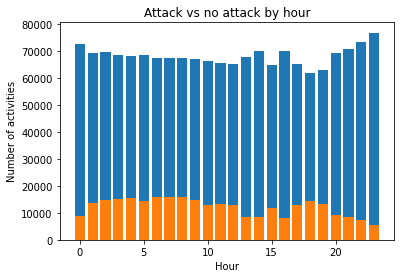

In [21]:
#compare attack and no attack activity for each hour

hour_0 = process_df.select("attack", "hour").filter(col("attack") == 0).groupby("hour")\
.agg(F.count("attack").alias('count')).rdd.map(lambda x: (x[0],x[1])).collect()


hour_1 = process_df.select("attack", "hour").filter(col("attack") == 1).groupby("hour")\
.agg(F.count("attack").alias('count')).rdd.map(lambda x: (x[0],x[1])).collect()

# extract hour and count
x = [item[0] for item in hour_0]
y = [item[1] for item in hour_0]

x_2 = [item[0] for item in hour_1]
y_2= [item[1] for item in hour_1]

%matplotlib inline

import matplotlib.pyplot as plt

plt.bar(x, y)
plt.bar(x_2, y_2)
plt.title("Attack vs no attack by hour")
plt.xlabel('Hour')
plt.ylabel('Number of activities')
plt.show()

From the plot above we can see that there is no very significant difference in hacking activity, however, there is more hacking activity between 1am and 12pm as well as in the early evening. The normal activities are highest in the late evening.

For the memory dataframe the hourly activity was checked as well, however, the trend was even less significant and thus will not be further explored.

Next, we will have a look at a correlation matrix to see which columns have the largest correlation with the attack activity.

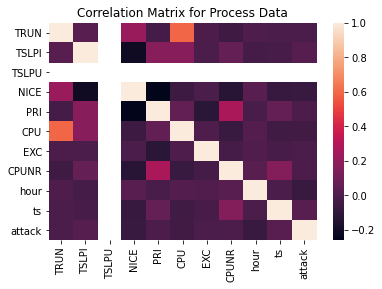

In [22]:
# !pip install seaborn
import seaborn as sns

# get numeric features and take sample of dataframe
process_sample = process_df.select("TRUN", "TSLPI", "TSLPU", "NICE", "PRI", "CPU", "EXC", "CPUNR", "hour", "ts", "attack")\
.sample(False, 0.001, seed=30).toPandas()


sns.heatmap(process_sample.corr()).set_title('Correlation Matrix for Process Data');

The correlation matrix for the process data shows us the relationship between each of the columns. Values close to 1 show a very strong positive correlation, and values close to -1 show a strongly negative correlation. Values close to zero indicate that there is no correlation between two features. 

 We can see that attack is not strongly correlated to any of the features. There is a fairly weak correlation between attack and Status, TSLPI, PRI and EXC. It seems that TSLPU could not be evaluated. This might be because its value is mostly zero (when looking at the summary statistics). The strongest correlation overall seems to be between CPU and TRUN. 

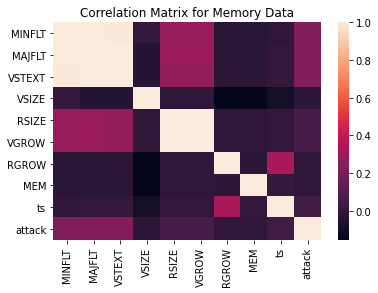

In [23]:
memory_sample = final_memory_df.select("MINFLT", "MAJFLT", "VSTEXT", "VSIZE", "RSIZE","VGROW", "RGROW", "MEM", "ts", "attack")\
.sample(False, 0.001, seed=30).toPandas()

memory_sample

sns.heatmap(memory_sample.corr()).set_title('Correlation Matrix for Memory Data');

The correlation matrix for the memory data shows that there are also no strong correlations between attack and any of the features, however, MINFLT, MAJFLT and VSTEXT are weakly correlated to attack. R-Size and VGROW seem to be weakly to moderately correlated to these three columns.

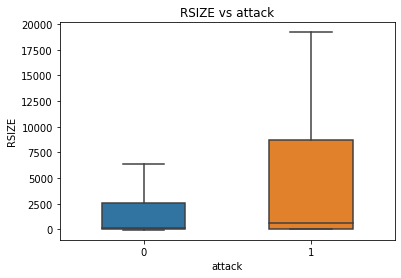

In [24]:
minflt_bplot = sns.boxplot(x='attack',y='RSIZE', data=memory_sample, width=0.5, showfliers=False)
minflt_bplot.set_title("RSIZE vs attack")
plt.show()

In the box plot below we see the spread of the data for RSIZE depending on whether there was an attack or no attack. Even though RSIZE did not show any significant correlation with attack, there is still an interesting pattern to see, as the RSIZE varies significantly more when there was an attack then when there wasn't. The median seems to be very similar, however, the IQR is much larger for attack events. It ranged from around 0 to around 8000, whereas for non attack events it ranges from around 0 to around 2500 only. So RSIZE might still be a good feature for our model.

## Feature extraction and ML training

### 2.1 Preparig the training data and testing data

#### 2.1.1 Randomly splitting data into train and test

In [25]:
#Splitting the data into testing and training set 80% for training and 20% for testing

process_train_temp, process_test = process_df.randomSplit([0.8, 0.2], seed=30)
memory_train_temp, memory_test = final_memory_df.randomSplit([0.8, 0.2], seed=30)

#### 2.1.2 Rebalancing the data

In [26]:
def rebalance(df):
    
    # taking 20% of the attack data
    temp_attack = df.filter(col("attack")==1).sample(False,0.2,seed=30)
    print("attacks: ", temp_attack.count())
    
    # calculating percentage of how much no attack data we need
    percentage = round(2* temp_attack.count() / df.filter(col("attack")==0).count(),4)
    
    # taking double the amount of attack data of the no attack data
    temp_normal = df.filter(col("attack")==0).sample(False,percentage,seed=30)
    print("no attack: ", temp_normal.count())
    
    print("attack + no attack: ", (temp_attack.count() + temp_normal.count()))
    
    # union of the two dataframes
    new_df = temp_attack.union(temp_normal)
    
    return new_df

In [27]:
process_train = rebalance(process_train_temp)
process_train.cache()

attacks:  46676
no attack:  93238
attack + no attack:  139914


DataFrame[ts: int, PID: int, TRUN: int, TSLPI: int, TSLPU: int, POLI: string, NICE: int, PRI: int, RTPR: int, CPUNR: int, Status: string, EXC: int, State: string, CPU: double, CMD: string, attack: int, type: string, date: date, hour: int]

In [28]:
memory_train = rebalance(memory_train_temp)
memory_train.cache()

attacks:  33094
no attack:  66287
attack + no attack:  99381


DataFrame[ts: int, PID: int, MINFLT: double, MAJFLT: double, VSTEXT: double, VSIZE: double, RSIZE: double, VGROW: double, RGROW: double, MEM: double, CMD: string, attack: int, type: string]

### 2.2 Preparing features, labels and models

#### 2.2.1 Feature selection

From the visualisation above we could see that are no strong or moderate correlations between attack and any of the features. This was the same for process and memory data. Also the feature engineered column "hour" did  not show any significant trend so we will not further consider it. ts also did not show any significant correlation with attack, and as mentioned further above, might not be that useful, because we cannot assume that attacks will happen on the same dates again in the future. It is thus not a suitable feature. 

We could observe some week correlations with attack, and some interesting trend for RSIZE in the memory dataset. So based on these observations the feature selection will be performed.

Process data:

- POLI
- Status
- TSLPI
- PRI
- EXC

POLI and Status are categorical data and for them string indexing and one hot encoding will be performed. EXC is numerical, however, the numbers don't have any ordinal meaning, thus it makes sense to also use one hot encoding for EXC. Then vector assembler will be used on all features. 

Memory data:

- MINFLT
- MAJFLT
- VSTEXT
- RSIZE

These are all numerical features and thus we can straight away use vector assembler.

We do not need to scale any of the features, as Decision Tree based models (like GBT) do not required scaled data because the distance between features is not relevant.

#### 2.2.2 Create Transformers / Etimators

Below reduced dataframes are created containing the selected features. The column name "attack" is changed to "label" as this is required for the model building stages.

In [29]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier

# use the features as discussed above
process_cols=['POLI', 'Status', 'TSLPI', 'PRI', 'EXC', 'attack']
process_reduced = process_train[process_cols]

# change name of column from attack to label
process_reduced = process_reduced.withColumnRenamed("attack", "label")
process_reduced.show(3)

# use the features as discussed above
memory_cols=['MINFLT', 'MAJFLT', 'VSTEXT', 'RSIZE', 'attack']
memory_reduced = memory_train[memory_cols]

# change name of column from attack to label
memory_reduced = memory_reduced.withColumnRenamed("attack", "label")
memory_reduced.show(3)

# change name of column from attack to label also in the test data
process_test = process_test.withColumnRenamed("attack", "label")
memory_test = memory_test.withColumnRenamed("attack", "label")

+----+------+-----+---+---+-----+
|POLI|Status|TSLPI|PRI|EXC|label|
+----+------+-----+---+---+-----+
|norm|     N|    1|120|  0|    1|
|norm|     N|    1|120|  0|    1|
|norm|     N|    1|120|  0|    1|
+----+------+-----+---+---+-----+
only showing top 3 rows

+------+------+-------+-----+-----+
|MINFLT|MAJFLT| VSTEXT|RSIZE|label|
+------+------+-------+-----+-----+
|   0.0|   0.0|    0.0|  0.0|    1|
| 132.0| 267.8|13664.0|  0.0|    1|
| 132.0| 224.2| 9336.0|  0.0|    1|
+------+------+-------+-----+-----+
only showing top 3 rows



As discussed above, for the process data we need to use string indexer, one hot encoder and then vector assembler.

In [30]:
# get all string type features
string_cols = [f.name for f in process_reduced.schema.fields if isinstance(f.dataType, StringType)]

# prepare string indexer
inputCols = [x for x in process_reduced.columns if x in string_cols]
outputCols = [f"{x}_idx" for x in process_reduced.columns if x in string_cols]

str_indexer = StringIndexer(inputCols=inputCols, outputCols=outputCols).setHandleInvalid("keep")

# prepare one hot encoder
inputCols_OHE = [x for x in outputCols] + ["EXC"]
outputCols_OHE = [f'{x}_vec' for x in (inputCols + ["EXC"])]

ohc = OneHotEncoder(inputCols=inputCols_OHE,
                        outputCols=outputCols_OHE)

# prepare vector assembler
inputCols_VA = [x for x in outputCols_OHE]\
+[x for x in process_reduced.columns if x not in string_cols and x != "EXC" and x != "label"]

process_assembler = VectorAssembler(inputCols=inputCols_VA, outputCol="features")

# check results of steps above
print(outputCols_OHE)
print(inputCols_VA)

['POLI_vec', 'Status_vec', 'EXC_vec']
['POLI_vec', 'Status_vec', 'EXC_vec', 'TSLPI', 'PRI']


As the features selected for the memory data are numerical we can straight away use the vector assembler

In [31]:
# preparing vector assembler
mem_assembler = VectorAssembler(
    inputCols= [col for col in memory_reduced.columns if col != "label"],
    outputCol="features")

#### 2.2.3 Prepare Estimators for Decision Tree and Gradient Boosted Tree

The decision tree and gradient boosted tree are initialised and will be amended using a parameter grid to find the most suitable parameters for the models. Due to computational limitations only a very limited amount of parameters could be tested. Of course, ideally, we would want to test a larger variety of parameters and some more values for each parameter. 

In [32]:
# initialising decision tree and gradient boosted tree

dt = DecisionTreeClassifier(featuresCol = 'features', 
                    labelCol = 'label', seed = 30)
gbt = GBTClassifier(featuresCol = 'features', 
                    labelCol = 'label', seed = 30)


In [33]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator,CrossValidatorModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create parameter grid for cross validation

dt_param_grid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [5, 10, 20])
             .addGrid(dt.maxBins, [20, 30, 40])
             .build())

gbt_param_grid = (ParamGridBuilder()
                .addGrid(gbt.maxDepth, [5, 15])
                .addGrid(gbt.maxIter, [10, 20])
                .addGrid(gbt.stepSize, [0.1, 0.2])
             .build())


In [34]:
# building all four pipelines (2 for process data and 2 for memory data)

process_pipeline_dt =  Pipeline(stages=[str_indexer,ohc,process_assembler, dt])
process_pipeline_gbt =  Pipeline(stages=[str_indexer,ohc,process_assembler, gbt])
mem_pipeline_dt =  Pipeline(stages=[mem_assembler,dt])
mem_pipeline_gbt =  Pipeline(stages=[mem_assembler,gbt])


In [35]:
# Define an evaluator to be used for evaluating the model 
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create 3-fold CrossValidator
dt_cv = CrossValidator(estimator = process_pipeline_dt,
                      estimatorParamMaps = dt_param_grid,
                      evaluator = evaluator,
                      numFolds = 3)

gbt_cv = CrossValidator(estimator = process_pipeline_gbt,
                      estimatorParamMaps = gbt_param_grid,
                      evaluator = evaluator,
                      numFolds = 3)

dt_cv_mem = CrossValidator(estimator = mem_pipeline_dt,
                      estimatorParamMaps = dt_param_grid,
                      evaluator = evaluator,
                      numFolds = 3)

gbt_cv_mem = CrossValidator(estimator = mem_pipeline_gbt,
                      estimatorParamMaps = gbt_param_grid,
                      evaluator = evaluator,
                      numFolds = 3)



### 2.3 Training and evaluating the models

#### 2.3.1 Training the models

In [36]:
# train the models with the parameter grid and cross validation

# for process data
dt_cv_model = dt_cv.fit(process_reduced)
gbt_cv_model = gbt_cv.fit(process_reduced)

In [37]:
# for memory data
dt_cv_mem_model = dt_cv_mem.fit(memory_reduced)
gbt_cv_mem_model = gbt_cv_mem.fit(memory_reduced)

In [38]:
# get best model and print its parameters

process_dt_best_model= dt_cv_model.bestModel
print('Best parameters for process DT: ', process_dt_best_model.stages[-1]._java_obj.paramMap())
process_dt_best_model= dt_cv_model.bestModel

process_gbt_best_model= gbt_cv_model.bestModel
print('Best parameters for process GBT: ', process_gbt_best_model.stages[-1]._java_obj.paramMap())
process_gbt_best_model= gbt_cv_model.bestModel

Best parameters for process DT:  {
	DecisionTreeClassifier_960162dca622-featuresCol: features,
	DecisionTreeClassifier_960162dca622-labelCol: label,
	DecisionTreeClassifier_960162dca622-maxBins: 20,
	DecisionTreeClassifier_960162dca622-maxDepth: 20,
	DecisionTreeClassifier_960162dca622-seed: 30
}
Best parameters for process GBT:  {
	GBTClassifier_7e190629308f-featuresCol: features,
	GBTClassifier_7e190629308f-labelCol: label,
	GBTClassifier_7e190629308f-maxDepth: 15,
	GBTClassifier_7e190629308f-maxIter: 20,
	GBTClassifier_7e190629308f-seed: 30,
	GBTClassifier_7e190629308f-stepSize: 0.1
}


In [39]:
mem_dt_best_model= dt_cv_mem_model.bestModel
#print(process_dt_best_model.stages)
print('Best parameters for memory DT: ', mem_dt_best_model.stages[-1]._java_obj.paramMap())
mem_dt_best_model= dt_cv_mem_model.bestModel

mem_gbt_best_model= gbt_cv_mem_model.bestModel
#print(process_dt_best_model.stages)
print('Best parameters for memory GBT: ', mem_gbt_best_model.stages[-1]._java_obj.paramMap())
mem_gbt_best_model= gbt_cv_mem_model.bestModel

Best parameters for memory DT:  {
	DecisionTreeClassifier_960162dca622-featuresCol: features,
	DecisionTreeClassifier_960162dca622-labelCol: label,
	DecisionTreeClassifier_960162dca622-maxBins: 40,
	DecisionTreeClassifier_960162dca622-maxDepth: 20,
	DecisionTreeClassifier_960162dca622-seed: 30
}
Best parameters for memory GBT:  {
	GBTClassifier_7e190629308f-featuresCol: features,
	GBTClassifier_7e190629308f-labelCol: label,
	GBTClassifier_7e190629308f-maxDepth: 15,
	GBTClassifier_7e190629308f-maxIter: 20,
	GBTClassifier_7e190629308f-seed: 30,
	GBTClassifier_7e190629308f-stepSize: 0.2
}


#### 2.3.2 Run model on test data and display confusion matrix

In [40]:
pred_process_dt = process_dt_best_model.transform(process_test)
pred_process_gbt = process_gbt_best_model.transform(process_test)
pred_mem_dt = mem_dt_best_model.transform(memory_test)
pred_mem_gbt = mem_gbt_best_model.transform(memory_test)

In [41]:
# show confusion matrix

def conf_matrix(prediction):
    prediction.groupBy('label', 'prediction').count().show()

conf_matrix(pred_process_dt)
conf_matrix(pred_process_gbt)



+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    1|       0.0| 41913|
|    0|       0.0|298033|
|    1|       1.0| 16261|
|    0|       1.0| 28720|
+-----+----------+------+

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    1|       0.0| 40560|
|    0|       0.0|294800|
|    1|       1.0| 17614|
|    0|       1.0| 31953|
+-----+----------+------+



In [42]:
conf_matrix(pred_mem_dt)
conf_matrix(pred_mem_gbt)

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    1|       0.0| 17543|
|    0|       0.0|318329|
|    1|       1.0| 23247|
|    0|       1.0| 40348|
+-----+----------+------+

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    1|       0.0| 17938|
|    0|       0.0|315087|
|    1|       1.0| 22852|
|    0|       1.0| 43590|
+-----+----------+------+



#### 2.3.3 Evaluation metrics

In [43]:
def metrics(prediction):

    TN = prediction.filter('prediction = 0 AND label = 0').count()
    TP = prediction.filter('prediction = 1 AND label = 1').count()
    FN = prediction.filter('prediction = 0 AND label = 1').count() 
    FP = prediction.filter('prediction = 1 AND label = 0').count() 
    
    accuracy = (TP+TN)/(TP+TN+FP+FN) 
    precision = TP/(TP+FP) 
    recall = TP/(TP+FN) 
    
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol='label')
    auc = evaluator.evaluate(prediction)
    
    print('AUC: %f\nAccuracy: %f\nPrecision: %f\nRecall: %f\n' % (auc,accuracy,precision,recall))
    

In [44]:
metrics(pred_process_dt)
metrics(pred_process_gbt)

AUC: 0.491938
Accuracy: 0.816503
Precision: 0.361508
Recall: 0.279523

AUC: 0.705533
Accuracy: 0.811619
Precision: 0.355357
Recall: 0.302781



In [45]:
metrics(pred_mem_dt)
metrics(pred_mem_gbt)

AUC: 0.609937
Accuracy: 0.855079
Precision: 0.365548
Recall: 0.569919

AUC: 0.836098
Accuracy: 0.845975
Precision: 0.343939
Recall: 0.560235



The AUC is a good overall metric for classification problems because it tells us how well the model can distinguish between two classes (0 and 1). An AUC of 0.5 means the model is as good as a random guess and an AUC of 1 means the model can perfectly distinguish between the classes. Thus, it is a good metric to evaluate our model. Another good measure in our scenario would be recall, because recall tells us how many of the positive cases we actually classified as positive. Since attacks can have serious consequences, we would want to put emphasis on recall. Accuracy is not a very good measure for imbalanced classes because if the model always predicts the class which occurs more frequently, it would still get a high accuracy even though the class with the lower frequency will not be predicted correctly at all (e.g. in our case we would get an accuracy of 0.66 if the model always predicts no attack happens).

In conclusion, we will focus on AUC and recall.

#### 2.3.4 Top features and ROC curve

In [46]:
import pandas as pd

def feature_importance(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))



Lin, T. (2018). *Feature Selection Using Feature Importance Score - Creating a PySpark Estimator*. Retrieved from: https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/

In [47]:
# most important features for process data with DT
feature_importance(process_dt_best_model.stages[-1]\
                  .featureImportances, process_dt_best_model.transform(process_reduced), "features").head(10)

,idx,name,score
5,3,Status_vec_-,0.545132
0,136,TSLPI,0.215767
1,137,PRI,0.103021
3,1,POLI_vec_0,0.064997
2,0,POLI_vec_norm,0.054939
6,4,Status_vec_0,0.012107
26,24,EXC_vec_15,0.002488
11,9,EXC_vec_0,0.001283
18,16,EXC_vec_7,0.000177
10,8,Status_vec_C,0.000088


In [48]:
# most important features for process data with GBT
feature_importance(process_gbt_best_model.stages[-1]\
                  .featureImportances, process_gbt_best_model.transform(process_reduced), "features").head(10)

,idx,name,score
5,3,Status_vec_-,0.409582
0,136,TSLPI,0.396905
1,137,PRI,0.099139
3,1,POLI_vec_0,0.046148
2,0,POLI_vec_norm,0.035198
6,4,Status_vec_0,0.008062
26,24,EXC_vec_15,0.002093
11,9,EXC_vec_0,0.000920
8,6,Status_vec_N,0.000624
111,109,EXC_vec_100,0.000247


The model consists only of 5 features, so there is no actual "top-5". We can see though that DT and GBT choose almost the same features as the most important ones. The most important one is Status, followed by TSLPI.

Choosing the better model:

When we look at the metrics for the process data we can see that decision tree gives an AUC of around 49% which is worse than just guessing, and a recall of only 28%. The GBT gives a significantly improved AUC of around 71% and roughly the same recall of around 30%. So we will choose the GBT model.

As discussed further above, ts will not be considered for the model as we would not expect the hackers to plan attacks for the same days each year again. However, the timestamp shows us that once an attack has started, there are more attacks to follow with a very high chance, as all the attacks happened within consecutive days. 

Also the information which was extracted from ts, namely hour, was not that significant. 

In [49]:
# most important features for memory data with DT
feature_importance(mem_dt_best_model.stages[-1]\
                  .featureImportances, mem_dt_best_model.transform(memory_reduced), "features").head(10)

,idx,name,score
3,3,RSIZE,0.378355
0,0,MINFLT,0.306639
2,2,VSTEXT,0.248710
1,1,MAJFLT,0.066296


In [50]:
# most important features for memory data with GBT
feature_importance(mem_gbt_best_model.stages[-1]\
                  .featureImportances, mem_gbt_best_model.transform(memory_reduced), "features").head(10)

,idx,name,score
3,3,RSIZE,0.400470
0,0,MINFLT,0.297404
2,2,VSTEXT,0.192232
1,1,MAJFLT,0.109894


For the memory data model we only passed in four features so again there is no "top-5". For both models, DT and GBT, the order of importance of the features is the same, only the scores for importance differ slightly. The most important feature is RSIZE, followed by MINFLT, then VSTEXT and last MAJFLT.

Choosing the better model:

The metrics for the memory data show and AUC of around 61% and a Recall of 57% for the DT. The GBT gives an AUC of around 84% and a recall of around 56%. Even though the GBT model gives a slightly worse recall, it still outperforms the DT overall, because the AUC is much higher. So we will choose the GBT model for the memory data as well.

In [51]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)
    
    # retrieve points from RDD and store in list
    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)
    

Ross, A. (2019). Answer to question: *pyspark extract ROC curve?* Retrieved from: https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve

In [52]:
def plot_auc(prediction):
    
    #Returns as a list (false positive rate, true positive rate)
    preds_process = prediction.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
    points = CurveMetrics(preds_process).get_curve('roc')

    plt.figure()
    x = [x[0] for x in points]
    y = [x[1] for x in points]
    plt.title("ROC Curve for GBT process model")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], 'b--')
    plt.plot(x, y, 'green')
    plt.show()

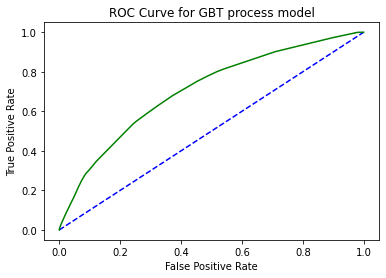

In [53]:
plot_auc(pred_process_gbt)

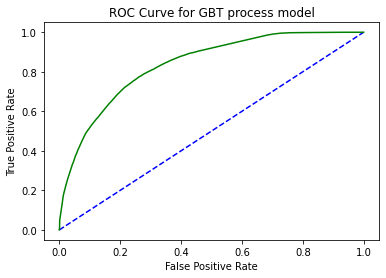

In [54]:
plot_auc(pred_mem_gbt)

#### 2.3.5 Retrain on larger subset of data and persist the models

In [55]:
# same function as used further above but now taking all attack data instead of only 20%
def rebalance_2(df):

    temp_attack = df.filter(col("attack")==1)
    print("attacks: ", temp_attack.count())

    percentage = round(2* temp_attack.count() / df.filter(col("attack")==0).count(),4)

    temp_normal = df.filter(col("attack")==0).sample(False,percentage,seed=30)
    print("no attack: ", temp_normal.count())
    
    print("attack + no attack: ", (temp_attack.count() + temp_normal.count()), "\n")
    
    new_df = temp_attack.union(temp_normal)
    
    return new_df

In [56]:
# full rebalanced training data

process_train_2 = rebalance_2(process_df)
memory_train_2 = rebalance_2(final_memory_df)

attacks:  291364
no attack:  582513
attack + no attack:  873877 

attacks:  205623
no attack:  411510
attack + no attack:  617133 



In [57]:
# change name of column "attack" to "label"

process_train_2 = process_train_2.withColumnRenamed("attack", "label")
memory_train_2 = memory_train_2.withColumnRenamed("attack", "label")

In [58]:
print(process_gbt_best_model.stages[-1]._java_obj.paramMap())

{
	GBTClassifier_7e190629308f-featuresCol: features,
	GBTClassifier_7e190629308f-labelCol: label,
	GBTClassifier_7e190629308f-maxDepth: 15,
	GBTClassifier_7e190629308f-maxIter: 20,
	GBTClassifier_7e190629308f-seed: 30,
	GBTClassifier_7e190629308f-stepSize: 0.1
}


In [59]:
print(mem_gbt_best_model.stages[-1]._java_obj.paramMap())

{
	GBTClassifier_7e190629308f-featuresCol: features,
	GBTClassifier_7e190629308f-labelCol: label,
	GBTClassifier_7e190629308f-maxDepth: 15,
	GBTClassifier_7e190629308f-maxIter: 20,
	GBTClassifier_7e190629308f-seed: 30,
	GBTClassifier_7e190629308f-stepSize: 0.2
}


In [60]:
# build new pipeline with the parameters of the best model from above

gbt_process = GBTClassifier(featuresCol="features", labelCol="label", maxDepth=5, maxIter=20, stepSize = 0.2)
pipeline_gbt_process = Pipeline(stages=[str_indexer,ohc,process_assembler, gbt_process])

final_process_model = pipeline_gbt_process.fit(process_train_2)

In [61]:
# build new pipeline with the parameters of the best model from above

gbt_memory = GBTClassifier(featuresCol="features", labelCol="label", maxDepth=15, maxIter=20, stepSize = 0.2)
pipeline_gbt_memory = Pipeline(stages=[mem_assembler,gbt_memory])

final_memory_model = pipeline_gbt_memory.fit(memory_train_2)

In [64]:
# Saving the model
final_process_model.save('process_gbt_model')
final_memory_model.save('memory_gbt_model')

## 3. Knowledge sharing

### 3.1 Spark UI

In [65]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

iris_df = spark.createDataFrame([
(4.7, 3.2, 1.3, 0.2),
(4.9, 3.1, 1.5, 0.1),
(5.4, 3.9, 1.3, 0.4),
(5.0, 3.4, 1.6, 0.4),
(5.1, 3.8, 1.6, 0.2),
(4.9, 2.4, 3.3, 1.0),
(6.6, 2.9, 4.6, 1.3),
(5.6, 3.0, 4.5, 1.5),
(5.7, 2.6, 3.5, 1.0),
(5.8, 2.6, 4.0, 1.2),
(5.8, 2.8, 5.1, 2.4),
(6.2, 2.8, 4.8, 1.8),
(6.0, 3.0, 4.8, 1.8),
(6.7, 3.1, 5.6, 2.4),
(6.7, 3.0, 5.2, 2.3),
(6.2, 3.4, 5.4, 2.3)],
['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])

assembler = VectorAssembler(
inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
outputCol='features')

kmeans = KMeans(k=3).fit(assembler.transform(iris_df))

The above code creates 10 Jobs for the k-mean clustering as the screenshot below pictures:

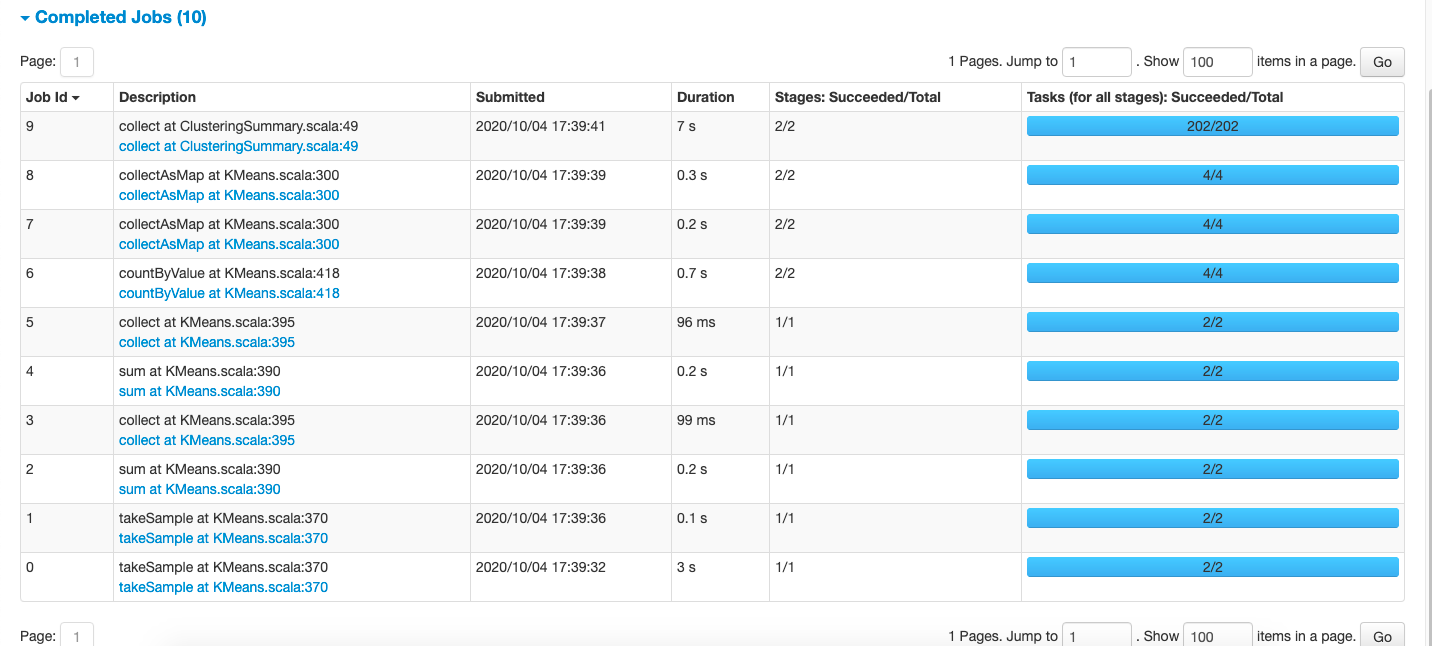

### 3.2 Explanation of Jobs

When looking at the Spark UI it seems Spark is implemeting data parallelism. In data parallelism, the data is distributed onto the available processors, for example by using Round Robin, and each processor has, in this case 3 clusters (k=3). The first two jobs are responsible for distributing the data. Then, for each data point the distance to each of the centroids is calculated, and the data points are grouped together to their closest centroid. This is done on each processor. Then the sum of datapoints in each cluster on each processor is calculated (job 2). The information is then collected to the central node, where the centroids are calculated and stored as a broadcasting variable and broadcasted to each processor (job 3). As k-mean clustering is an iterative process, the sequence of jobs repeats. Finally, the clusters of each processor are collected to the central node and merged together (jobs 7 to 9).

Wang, B., Yin, J., Hua, Q., Wu, Z., Cao, J. (2016). *Parallelizing K-means-based Clustering on Spark*. Conference Paper for the 2016 International Conference on Advanced Cloud and Big Data. Retrieved from: https://www.researchgate.net/publication/312487404_Parallelizing_K-Means-Based_Clustering_on_Spark